In [1]:
#!pip install tsfresh --user
#!pip install pytorch_toolbelt --user

In [2]:
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
#import torchvision
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

import pickle
import gc
import random
import os
import time
#from apex import amp
from sklearn.model_selection import KFold
from tsfresh.feature_extraction.feature_calculators import linear_trend, kurtosis, quantile, skewness, mean_second_derivative_central, sample_entropy
from tqdm.notebook import tqdm
from pytorch_toolbelt import losses as L
from scipy import signal
os.listdir('./input')

['sample_submission.csv',
 'Y_test_proba.npy',
 'train.csv',
 'test_kalman.csv',
 'test.csv',
 'Y_train_proba.npy',
 'train_kalman.csv',
 'liverpool-ion-switching.zip']

In [3]:
print(torch.__version__) 

1.4.0


In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
train = pd.read_csv('./input/train_kalman.csv')
test = pd.read_csv('./input/test_kalman.csv')
test_pseudo_labels = pd.read_csv("submission_20200501.csv")['open_channels'].values
Y_train_proba = np.load("./input/Y_train_proba.npy")
Y_test_proba  = np.load("./input/Y_test_proba.npy") 

for i in range(11):
    train[f"proba_{i}"] = Y_train_proba[:, i]
    test[f"proba_{i}"] = Y_test_proba[:, i]

num_class  = len(train['open_channels'].unique())
lr         = 1e-3
batch_size = 64
multi_step = [30, 50, 60]
epochs     = 100
n_fold     = 5
seq_length = 1000

## Feature Engineering

In [7]:
def feature_generator_1(df, window_sizes, groups, 
                        add_pct_change = False,
                        shift_sizes = None, 
                        add_signal_shift = False,
                        add_signal_shift_lag = False):
    
    no_substract_cols = []
    
    df['signal_2'] = df['signal'] ** 2
    
    if add_pct_change:
        for group_id in groups:
            no_substract_cols.append('pct_change')
            idx = np.arange(group_id*500000, (group_id+1)*500000)
            df.loc[idx, 'pct_change'] = df[df.group == group_id]['signal'].pct_change()
    
    for window in tqdm(window_sizes):
        no_substract_cols.append("rolling_std_" + str(window))
        no_substract_cols.append("rolling_max_" + str(window))
        no_substract_cols.append("rolling_mean_" + str(window))
            
        for group_id in groups:
            idx = np.arange(group_id*500000, (group_id+1)*500000)
            df.loc[idx, "rolling_mean_" + str(window)] = df[df.group == group_id]['signal'].rolling(window=window).mean()
            df.loc[idx, "rolling_std_" + str(window)]  = df[df.group == group_id]['signal'].rolling(window=window).std()
            df.loc[idx, "rolling_min_" + str(window)]  = df[df.group == group_id]['signal'].rolling(window=window).min()
            df.loc[idx, "rolling_max_" + str(window)]  = df[df.group == group_id]['signal'].rolling(window=window).max()

        
        df["rolling_min_" + str(window)+'_s'] = df["rolling_min_" + str(window)] - df.signal
        df["rolling_std_" + str(window)+'_s'] = df["rolling_std_" + str(window)] - df.signal
        df = df.drop(columns=["rolling_min_" + str(window), "rolling_std_" + str(window)])
    
    if shift_sizes is not None:
        for shift_size in tqdm(shift_sizes):
            no_substract_cols.append('pct_change_shift_pos_'+str(shift_size))
            no_substract_cols.append('pct_change_shift_neg_'+str(shift_size))
            if add_pct_change:
                df.loc[idx , 'pct_change_shift_pos_'+str(shift_size)] = df[df.group == group_id]['pct_change'].shift(shift_size).astype(np.float64)
                df.loc[idx , 'pct_change_shift_neg_'+str(shift_size)] = df[df.group == group_id]['pct_change'].shift(-1*shift_size).astype(np.float64)
            if add_signal_shift:
                df.loc[idx , 'signal_shift_pos_'+str(shift_size)] = df[df.group == group_id]['signal'].shift(shift_size).astype(np.float64)
                df.loc[idx , 'signal_shift_neg_'+str(shift_size)] = df[df.group == group_id]['signal'].shift(-1*shift_size).astype(np.float64)
            if add_signal_shift_lag:        
                df['signal_shift_pos_'+str(shift_size)+'_s'] = df['signal_shift_pos_'+str(shift_size)] - df.signal
                df['signal_shift_neg_'+str(shift_size)+'_s'] = df['signal_shift_neg_'+str(shift_size)] - df.signal
                df = df.drop(columns=['signal_shift_pos_'+str(shift_size), 'signal_shift_neg_'+str(shift_size)])   
                    
    df = df.replace([np.inf, -np.inf], np.nan)
    df.fillna(0, inplace=True)
    
    return df, no_substract_cols

def feature_generator_2(df, batch_sizes, windows_sizes=None):
    
    df = df.sort_values(by=['time']).reset_index(drop=True)
    df.index = ((df.time * 10_000) - 1).values
    
    for batch_size in tqdm(batch_sizes):
        
        df['batch']         = df.index // batch_size
        df['batch_index']   = df.index  - (df.batch * batch_size)
        df['batch_slices']  = df['batch_index']  // (batch_size / 10)
        df['batch_slices2'] = df['batch'].astype(str).str.zfill(3) + '_' + df['batch_slices'].astype(str).str.zfill(3)
        
        for c in ['batch', 'batch_slices2']:
            d = {}
            d['mean_{}_{}'.format(c, batch_size)]   = df.groupby([c])['signal'].mean()
            d['median_{}_{}'.format(c, batch_size)] = df.groupby([c])['signal'].median()
            d['max_{}_{}'.format(c, batch_size)]    = df.groupby([c])['signal'].max()
            d['min_{}_{}'.format(c, batch_size)]    = df.groupby([c])['signal'].min()
            d['std_{}_{}'.format(c, batch_size)]    = df.groupby([c])['signal'].std()
            d['mean_abs_chg_{}_{}'.format(c, batch_size)] = df.groupby([c])['signal'].apply(lambda x: np.mean(np.abs(np.diff(x))))
            d['abs_max_{}_{}'.format(c, batch_size)] = df.groupby([c])['signal'].apply(lambda x: np.max(np.abs(x)))
            d['abs_min_{}_{}'.format(c, batch_size)] = df.groupby([c])['signal'].apply(lambda x: np.min(np.abs(x)))
            for v in d:
                df[v] = df[c].map(d[v].to_dict())
            df['range_{}_{}'.format(c, batch_size)] = df['max_{}_{}'.format(c, batch_size)] - df['min_{}_{}'.format(c, batch_size)]
            df['maxtomin_{}_{}'.format(c, batch_size)] = df['max_{}_{}'.format(c, batch_size)] / df['min_{}_{}'.format(c, batch_size)]
            df['abs_avg_{}_{}'.format(c, batch_size)] = (df['abs_min_{}_{}'.format(c, batch_size)] + df['abs_max_{}_{}'.format(c, batch_size)]) / 2
            
            #substruct features
            df['min_{}_{}'.format(batch_size, c)+ '_s'] = df['min_{}_{}'.format(c, batch_size)] - df['signal']
            df['std_{}_{}'.format(batch_size, c)+ '_s'] = df['std_{}_{}'.format(c, batch_size)] - df['signal']
            df['mean_abs_chg_{}_{}'.format(batch_size, c) + '_s'] = df['mean_abs_chg_{}_{}'.format(c, batch_size)] - df['signal']
            df['abs_min_{}_{}'.format(batch_size, c)+ '_s'] = df['abs_min_{}_{}'.format(c, batch_size)] - df['signal']
            df['abs_avg_{}_{}'.format(batch_size, c) + '_s'] = df['abs_avg_{}_{}'.format(c, batch_size)] - df['signal']
            
            df = df.drop(columns=['min_{}_{}'.format(c, batch_size), 
                                  'abs_min_{}_{}'.format(c, batch_size),
                                  'abs_avg_{}_{}'.format(c, batch_size)])
    
    df = df.replace([np.inf, -np.inf], np.nan)
    df.fillna(0, inplace=True)
    
    return df

In [8]:
def add_bathing_to_data(df : pd.DataFrame) -> pd.DataFrame :
    batches = df.shape[0] // 500000
    df['group'] = 0
    for i in range(batches):
        idx = np.arange(i*500000, (i+1)*500000)
        df.loc[idx, 'group'] = i
        
    return df, df.group.unique()

train, train_group = add_bathing_to_data(train)
test, test_group   = add_bathing_to_data(test)

In [9]:
windows_sizes=[1000, 5000]
train, no_substract_cols = feature_generator_1(train, 
                                               windows_sizes, 
                                               train_group, 
                                               add_pct_change=False, 
                                               shift_sizes=None, 
                                               add_signal_shift=False,
                                               add_signal_shift_lag=False)


test, _ = feature_generator_1(test, 
                              windows_sizes, 
                              test_group, 
                              add_pct_change=False, 
                              shift_sizes=None, 
                              add_signal_shift=False,
                              add_signal_shift_lag=False)

In [10]:
train = feature_generator_2(train, batch_sizes=[50000])
test  = feature_generator_2(test, batch_sizes=[50000]) 

In [11]:
train_y = train['open_channels'].values


train_x = train.drop(columns=['time', 'open_channels', 'group',
                              'batch', 
                              'batch_index', 
                              'batch_slices', 
                              'batch_slices2',
                             ])

test.drop(columns=['time', 
                   'batch', 
                   'group',
                   'batch_index', 
                   'batch_slices', 
                   'batch_slices2',
                  ], inplace=True)

In [12]:
train_x.columns

Index(['signal', 'proba_0', 'proba_1', 'proba_2', 'proba_3', 'proba_4',
       'proba_5', 'proba_6', 'proba_7', 'proba_8', 'proba_9', 'proba_10',
       'signal_2', 'rolling_mean_1000', 'rolling_max_1000',
       'rolling_min_1000_s', 'rolling_std_1000_s', 'rolling_mean_5000',
       'rolling_max_5000', 'rolling_min_5000_s', 'rolling_std_5000_s',
       'mean_batch_50000', 'median_batch_50000', 'max_batch_50000',
       'std_batch_50000', 'mean_abs_chg_batch_50000', 'abs_max_batch_50000',
       'range_batch_50000', 'maxtomin_batch_50000', 'min_50000_batch_s',
       'std_50000_batch_s', 'mean_abs_chg_50000_batch_s',
       'abs_min_50000_batch_s', 'abs_avg_50000_batch_s',
       'mean_batch_slices2_50000', 'median_batch_slices2_50000',
       'max_batch_slices2_50000', 'std_batch_slices2_50000',
       'mean_abs_chg_batch_slices2_50000', 'abs_max_batch_slices2_50000',
       'range_batch_slices2_50000', 'maxtomin_batch_slices2_50000',
       'min_50000_batch_slices2_s', 'std_50000_bat

In [13]:
del train
gc.collect()

68

In [14]:
scaler = StandardScaler()
scaler.fit(train_x)
train_x = scaler.transform(train_x)
test_x_scaled  = scaler.transform(test)

with open('scaler.pickle', mode='wb') as f:
    pickle.dump(scaler, f)

In [15]:
train_x = np.concatenate([train_x, test_x_scaled], 0)
train_y = np.concatenate([train_y, test_pseudo_labels], 0)

In [16]:
train_x_scaled_reshaped = train_x.reshape(-1, seq_length, train_x.shape[1])
train_y                 = train_y.reshape(-1, seq_length)
test_x_scaled_reshaped  = test_x_scaled.reshape(-1, seq_length, test_x_scaled.shape[1])
print(train_x_scaled_reshaped.shape)
print(test_x_scaled_reshaped.shape)

(7000, 1000, 47)
(2000, 1000, 47)


In [17]:
del train_x
del test_x_scaled
gc.collect()

80

## DataLoader

In [18]:
class IonDataset(Dataset):

    def __init__(self, X, y=None, augment=False):
                
        self.inputs = X
        self.labels = y
        self.augment = augment

    def __len__(self):
        return self.inputs.shape[0]

    def __getitem__(self, idx):
        
        input = self.inputs[idx]
        
        if self.labels is not None:
            
            if self.augment:
                if np.random.rand() < 0.5:
                    return np.flip(input, 0).copy(), np.flip(self.labels[idx],0).copy()
                else:
                    return input, self.labels[idx]
            return input, self.labels[idx]
        else:
            return input

# Model

In [19]:
sigmoid = torch.nn.Sigmoid()
class Swish(torch.autograd.Function):
    @staticmethod
    def forward(ctx, i):
        result = i * sigmoid(i)
        ctx.save_for_backward(i)
        return result

    @staticmethod
    def backward(ctx, grad_output):
        i = ctx.saved_variables[0]
        sigmoid_i = sigmoid(i)
        return grad_output * (sigmoid_i * (1 + i * (1 - sigmoid_i)))

swish = Swish.apply

class Swish_module(nn.Module):
    def forward(self, x):
        return swish(x)

class IonModel(nn.Module):
    
    def __init__(self, input_dim, num_class, num_hidden, out_channel):
        super(IonModel, self).__init__()
        
        self.cnn1 = nn.Sequential(nn.Conv1d(input_dim, out_channel//2, kernel_size=1, padding=0, stride=1),
                                  Swish_module())
        self.cnn2 = nn.Sequential(nn.Conv1d(input_dim, out_channel//2, kernel_size=3, padding=1, stride=1),
                                  Swish_module())
        
        self.gru1     = nn.GRU(out_channel, num_hidden, batch_first=True, bidirectional=True)
        self.dropout  = nn.Dropout(0.7)
        self.gru2     = nn.GRU((num_hidden*2+out_channel), num_hidden, batch_first=True, bidirectional=True)
        self.gru3     = nn.GRU((num_hidden*4+out_channel), num_hidden, batch_first=True, bidirectional=True)
        self.fc = nn.Sequential(nn.Linear((num_hidden*6+out_channel), num_hidden*2),
                                nn.ReLU(inplace=True),
                                nn.Linear(num_hidden*2, num_class))
        
        
    
    def forward(self, input):
        
        input = torch.transpose(input, 1, 2)
        cnn_output1 = self.cnn1(input)
        cnn_output2 = self.cnn2(input)
        cnn_output  = torch.cat((cnn_output1, cnn_output2), 1)
        rnn_input   = torch.transpose(cnn_output, 1, 2)
        
        gru1, _     = self.gru1(rnn_input)
        gru1        = self.dropout(gru1)
        gru1        = torch.cat((rnn_input, gru1), 2) #densely connected recurrent network https://arxiv.org/pdf/1707.06130.pdf
        gru2, _     = self.gru2(gru1)
        gru2        = self.dropout(gru2)
        gru2        = torch.cat((gru1, gru2), 2)
        gru3, _     = self.gru3(gru2)
        gru3        = self.dropout(gru3)
        gru3        = torch.cat((gru2, gru3), 2)
        
        output = self.fc(gru3)
        
        return output

In [20]:
def model_test():
    m = IonModel(31, 10, 64, 64)
    input = torch.randn(20, 16, 31)
    print(m(input).size())

In [21]:
model_test()

torch.Size([20, 16, 10])


## Train Model

In [22]:
def train_model(model, criterion, train_loader, optimizer):
    avg_loss = 0.0
    model.train()
    for idx, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.float().to(device)
        labels = labels.long().to(device)
        output_train = model(inputs)
        loss = criterion(torch.transpose(output_train, 1, 2), labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        avg_loss += loss.item() / len(train_loader)
        
    return avg_loss

def val_model(model, criterion, val_loader):
    avg_val_loss = 0.0
    preds = []
    original = []
    model.eval()
    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(val_loader):
            inputs = inputs.float().to(device)
            labels = labels.long().to(device)
            output_val = model(inputs)
            loss = criterion(torch.transpose(output_val, 1, 2), labels)
            avg_val_loss += loss.item() / len(val_loader)
            preds.append(np.argmax(F.softmax(output_val, 2).detach().cpu().numpy(), 2).reshape(-1))
            original.append(labels.detach().cpu().numpy().reshape(-1))
        
        truths = np.concatenate(original)
        preds  = np.concatenate(preds)
        
        score = f1_score(truths, preds, average='macro')
        
    return avg_val_loss, score

In [23]:
best_sub = pd.read_csv('best_submission_2.csv').open_channels.values.astype(int)

In [24]:
def predict_result(model, test_loader, batch_size=16):
    
    output = np.zeros((len(test), num_class))
    model.eval()
    with torch.no_grad():
        for idx, inputs in enumerate(test_loader):
            start_index = idx * batch_size*seq_length
            end_index   = min(start_index + batch_size*seq_length, len(test))
            inputs = inputs.float().to(device)
            preds  = model(inputs)
            preds  = F.softmax(preds, 2).detach().cpu().numpy().reshape(-1, num_class)
            output[start_index:end_index, :] = preds
            
    result_test = np.argmax(output, 1).astype(np.int)
    print(f1_score(best_sub, result_test, average='macro'))
    
    return output

In [25]:
def train_model_kfold():
    
    seed_everything(2020)
    folds = KFold(n_splits=n_fold, shuffle=True, random_state=42)
    
    test_set    = IonDataset(test_x_scaled_reshaped)
    test_loader = DataLoader(test_set, batch_size=16, shuffle=False)
    result      = 0
    
    for fold_n, (train_index, valid_index) in enumerate(folds.split(train_x_scaled_reshaped)):
        print('Fold', fold_n, 'started at', time.ctime())
        X_train, X_valid = train_x_scaled_reshaped[train_index], train_x_scaled_reshaped[valid_index]
        y_train, y_valid = train_y[train_index], train_y[valid_index]
    
        train_set    = IonDataset(X_train, y_train, augment=False)
        train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=4)
        val_set      = IonDataset(X_valid, y_valid)
        val_loader   = DataLoader(val_set, batch_size=batch_size, shuffle=False)
    
        model = IonModel(train_x_scaled_reshaped.shape[-1], num_class, 128, 128)
        model.to(device)
        
        best_avg_loss    = 100.0
        best_score       = 0.0
        best_param_loss  = None
        best_param_score = None
        i = 0
        
        optimizer = torch.optim.Adam(model.parameters(), lr, weight_decay=1e-6)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
        criterion = L.FocalLoss()
        
        for epoch in range(epochs):
        
            #if i == 10: break
            start_time          = time.time()
            avg_loss            = train_model(model, criterion, train_loader, optimizer)
            avg_val_loss, score = val_model(model, criterion, val_loader)
            elapsed_time = time.time() - start_time 
            print('Epoch {}/{} \t loss={:.4f} \t val_loss={:.4f} \t score={:.6f} \t time={:.2f}s'.format(epoch + 1,
                                                                                                         epochs, 
                                                                                                         avg_loss, 
                                                                                                         avg_val_loss,
                                                                                                         score, 
                                                                                                         elapsed_time))
    
            if best_avg_loss > avg_val_loss:
                i = 0
                best_avg_loss = avg_val_loss 
                best_param_loss = model.state_dict()
            if best_score < score:
                best_score = score
                best_param_score = model.state_dict()
            else:
                i += 1
            scheduler.step()
            
        model.load_state_dict(best_param_score)
        result += predict_result(model, test_loader)
        
    return result

In [26]:
result = train_model_kfold()
result /= n_fold
final_output = np.argmax(result, 1).astype(np.int)

Fold 0 started at Sun May  3 12:41:29 2020


/home/chanhu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: 'saved_variables' is deprecated; use 'saved_tensors'
  # This is added back by InteractiveShellApp.init_path()


Epoch 1/100 	 loss=0.1639 	 val_loss=0.0399 	 score=0.945857 	 time=22.99s
Epoch 2/100 	 loss=0.0453 	 val_loss=0.0378 	 score=0.946161 	 time=22.98s
Epoch 3/100 	 loss=0.0430 	 val_loss=0.0368 	 score=0.946260 	 time=22.96s
Epoch 4/100 	 loss=0.0418 	 val_loss=0.0359 	 score=0.946164 	 time=22.82s
Epoch 5/100 	 loss=0.0408 	 val_loss=0.0353 	 score=0.946249 	 time=22.82s
Epoch 6/100 	 loss=0.0401 	 val_loss=0.0348 	 score=0.946287 	 time=22.92s
Epoch 7/100 	 loss=0.0395 	 val_loss=0.0345 	 score=0.946067 	 time=22.85s
Epoch 8/100 	 loss=0.0389 	 val_loss=0.0336 	 score=0.946130 	 time=22.95s
Epoch 9/100 	 loss=0.0384 	 val_loss=0.0334 	 score=0.946266 	 time=22.82s
Epoch 10/100 	 loss=0.0379 	 val_loss=0.0329 	 score=0.946313 	 time=22.84s
Epoch 11/100 	 loss=0.0376 	 val_loss=0.0329 	 score=0.946412 	 time=22.84s
Epoch 12/100 	 loss=0.0373 	 val_loss=0.0330 	 score=0.946290 	 time=22.82s
Epoch 13/100 	 loss=0.0372 	 val_loss=0.0325 	 score=0.946436 	 time=21.29s
Epoch 14/100 	 loss=0

Epoch 9/100 	 loss=0.0377 	 val_loss=0.0372 	 score=0.943998 	 time=22.59s
Epoch 10/100 	 loss=0.0375 	 val_loss=0.0367 	 score=0.944057 	 time=23.00s
Epoch 11/100 	 loss=0.0372 	 val_loss=0.0364 	 score=0.944199 	 time=22.88s
Epoch 12/100 	 loss=0.0365 	 val_loss=0.0364 	 score=0.944361 	 time=23.01s
Epoch 13/100 	 loss=0.0364 	 val_loss=0.0357 	 score=0.944571 	 time=22.34s
Epoch 14/100 	 loss=0.0363 	 val_loss=0.0359 	 score=0.944219 	 time=22.67s
Epoch 15/100 	 loss=0.0357 	 val_loss=0.0358 	 score=0.944292 	 time=22.75s
Epoch 16/100 	 loss=0.0356 	 val_loss=0.0356 	 score=0.944571 	 time=22.33s
Epoch 17/100 	 loss=0.0355 	 val_loss=0.0355 	 score=0.944288 	 time=22.69s
Epoch 18/100 	 loss=0.0353 	 val_loss=0.0350 	 score=0.944584 	 time=22.62s
Epoch 19/100 	 loss=0.0352 	 val_loss=0.0351 	 score=0.944338 	 time=22.57s
Epoch 20/100 	 loss=0.0351 	 val_loss=0.0351 	 score=0.944742 	 time=22.69s
Epoch 21/100 	 loss=0.0349 	 val_loss=0.0348 	 score=0.944975 	 time=22.37s
Epoch 22/100 

Epoch 17/100 	 loss=0.0352 	 val_loss=0.0367 	 score=0.944370 	 time=21.02s
Epoch 18/100 	 loss=0.0350 	 val_loss=0.0360 	 score=0.944952 	 time=20.86s
Epoch 19/100 	 loss=0.0350 	 val_loss=0.0360 	 score=0.944901 	 time=20.85s
Epoch 20/100 	 loss=0.0348 	 val_loss=0.0360 	 score=0.945062 	 time=20.82s
Epoch 21/100 	 loss=0.0346 	 val_loss=0.0358 	 score=0.945136 	 time=21.17s
Epoch 22/100 	 loss=0.0346 	 val_loss=0.0360 	 score=0.944728 	 time=20.87s
Epoch 23/100 	 loss=0.0345 	 val_loss=0.0356 	 score=0.945178 	 time=20.93s
Epoch 24/100 	 loss=0.0344 	 val_loss=0.0359 	 score=0.944975 	 time=20.96s
Epoch 25/100 	 loss=0.0341 	 val_loss=0.0354 	 score=0.946367 	 time=21.01s
Epoch 26/100 	 loss=0.0340 	 val_loss=0.0353 	 score=0.946206 	 time=21.20s
Epoch 27/100 	 loss=0.0339 	 val_loss=0.0355 	 score=0.946533 	 time=21.13s
Epoch 28/100 	 loss=0.0338 	 val_loss=0.0351 	 score=0.946324 	 time=20.70s
Epoch 29/100 	 loss=0.0339 	 val_loss=0.0355 	 score=0.945844 	 time=20.94s
Epoch 30/100

Epoch 25/100 	 loss=0.0347 	 val_loss=0.0345 	 score=0.944561 	 time=21.06s
Epoch 26/100 	 loss=0.0346 	 val_loss=0.0347 	 score=0.944647 	 time=20.80s
Epoch 27/100 	 loss=0.0343 	 val_loss=0.0346 	 score=0.945107 	 time=20.87s
Epoch 28/100 	 loss=0.0342 	 val_loss=0.0343 	 score=0.945290 	 time=20.80s
Epoch 29/100 	 loss=0.0342 	 val_loss=0.0343 	 score=0.945462 	 time=20.83s
Epoch 30/100 	 loss=0.0340 	 val_loss=0.0343 	 score=0.945334 	 time=21.06s
Epoch 31/100 	 loss=0.0339 	 val_loss=0.0342 	 score=0.946137 	 time=21.05s
Epoch 32/100 	 loss=0.0337 	 val_loss=0.0339 	 score=0.944894 	 time=21.83s
Epoch 33/100 	 loss=0.0338 	 val_loss=0.0336 	 score=0.946498 	 time=21.03s
Epoch 34/100 	 loss=0.0335 	 val_loss=0.0335 	 score=0.946904 	 time=20.95s
Epoch 35/100 	 loss=0.0334 	 val_loss=0.0337 	 score=0.946663 	 time=20.77s
Epoch 36/100 	 loss=0.0335 	 val_loss=0.0334 	 score=0.946789 	 time=20.76s
Epoch 37/100 	 loss=0.0331 	 val_loss=0.0338 	 score=0.946230 	 time=20.87s
Epoch 38/100

Epoch 33/100 	 loss=0.0337 	 val_loss=0.0330 	 score=0.949571 	 time=22.87s
Epoch 34/100 	 loss=0.0337 	 val_loss=0.0327 	 score=0.950415 	 time=23.12s
Epoch 35/100 	 loss=0.0336 	 val_loss=0.0324 	 score=0.950974 	 time=22.81s
Epoch 36/100 	 loss=0.0334 	 val_loss=0.0326 	 score=0.950686 	 time=22.92s
Epoch 37/100 	 loss=0.0333 	 val_loss=0.0325 	 score=0.951029 	 time=22.79s
Epoch 38/100 	 loss=0.0333 	 val_loss=0.0325 	 score=0.951026 	 time=22.94s
Epoch 39/100 	 loss=0.0332 	 val_loss=0.0330 	 score=0.949219 	 time=22.82s
Epoch 40/100 	 loss=0.0331 	 val_loss=0.0322 	 score=0.951406 	 time=22.83s
Epoch 41/100 	 loss=0.0329 	 val_loss=0.0324 	 score=0.951262 	 time=22.79s
Epoch 42/100 	 loss=0.0330 	 val_loss=0.0324 	 score=0.951376 	 time=22.79s
Epoch 43/100 	 loss=0.0331 	 val_loss=0.0323 	 score=0.951076 	 time=22.68s
Epoch 44/100 	 loss=0.0329 	 val_loss=0.0322 	 score=0.951406 	 time=22.77s
Epoch 45/100 	 loss=0.0328 	 val_loss=0.0321 	 score=0.951594 	 time=23.04s
Epoch 46/100

In [27]:
sample_df = pd.read_csv("./input/sample_submission.csv", dtype={'time':str})
sample_df['open_channels'] = final_output
sample_df.to_csv("submission_cnn_lstm_20200503_00.csv", index=False, float_format='%.4f')

In [28]:
sample_df.head()

,time,open_channels
0,500.0001,0
1,500.0002,0
2,500.0003,0
3,500.0004,0
4,500.0005,0


In [29]:
#0.9887122108964345
f1_score(best_sub, sample_df.open_channels, average='macro')

0.9238665636191566

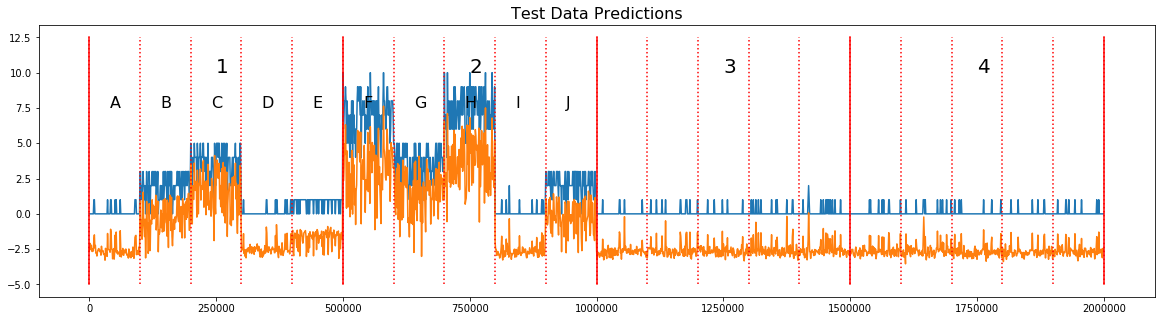

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,5))
res = 1000
let = ['A','B','C','D','E','F','G','H','I','J']
plt.plot(range(0,test.shape[0],res),sample_df.open_channels[0::res])
plt.plot(range(0,test.shape[0],res),test.signal[0::res])
for i in range(5): plt.plot([i*500000,i*500000],[-5,12.5],'r')
for i in range(21): plt.plot([i*100000,i*100000],[-5,12.5],'r:')
for k in range(4): plt.text(k*500000+250000,10,str(k+1),size=20)
for k in range(10): plt.text(k*100000+40000,7.5,let[k],size=16)
plt.title('Test Data Predictions',size=16)
plt.show()